# Bus stops and metro stations in the Paris area

In [1]:
from pathlib import Path
import csv
import numpy as np

plot_dir = Path('_plots_stations')
ext = 'png'

# Read longitude and latitude and department from CSV file
lon, lat, dept = [], [], []
with open('../positions-geographiques.csv') as csvfile:
    for irow, row in enumerate(csv.reader(csvfile, delimiter=';')):
        if irow > 0 and len(row):  # for some reason, one every two row is empty
            lat.append(float(row[4]))
            lon.append(float(row[5]))
            dept.append(int(row[-1]))
lon, lat, dept = map(np.array, [lon, lat, dept])

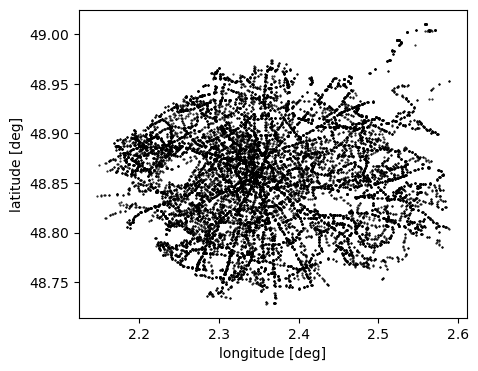

In [2]:
from matplotlib import pyplot as plt
kw_fig = dict(bbox_inches='tight', pad_inches=0.1, dpi=200)
fig, ax = plt.subplots(figsize=(5, 4))

# Exclude some surrounding departments, to make the map more compact
mask = ~np.isin(dept, [77, 78, 91, 95])
ax.scatter(lon[mask], lat[mask], marker='.', s=1, color='k')
ax.set_xlabel('longitude [deg]')
ax.set_ylabel('latitude [deg]')
fig.savefig(plot_dir / 'map_data_lonlat.{}'.format(ext), **kw_fig)

In [3]:
# Convert longitude and latitude to Cartesian coordinates

def get_xy(lon, lat):
    d = 6371  # Earth radius in kilometers at Paris latitude
    # Convert degrees to radians and center the coordinates
    conv = np.pi / 180.
    phi_theta = np.column_stack([lon, lat]) * conv
    phi_theta -= np.mean(phi_theta, axis=0)
    return phi_theta * d

data_positions = get_xy(lon, lat)[mask]

/tmp/ipykernel_1126603/2904310541.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncols=2, loc=1, frameon=False)


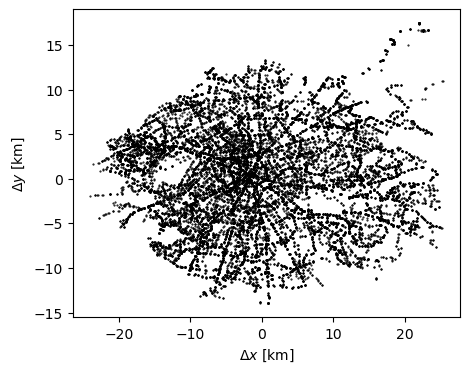

In [4]:
fig, ax = plt.subplots(figsize=(5, 4))
# Scatter plot of random points and data points
ax.scatter(data_positions[:, 0], data_positions[:, 1], marker='.', s=1, color='k')
ax.set_xlabel('$\Delta x$ [km]')
ax.set_ylabel('$\Delta y$ [km]')
ax.legend(ncols=2, loc=1, frameon=False)
fig.savefig(plot_dir / 'map_data.{}'.format(ext), **kw_fig)

In [5]:
from numba import njit

# Count pairs of points within a distance range
@njit
def pair_count_2d(positions, edges):
    counts = np.zeros(len(edges) - 1)
    for i in range(positions.shape[0]):
        for j in range(i + 1, positions.shape[0]):
            dx = positions[i, 0] - positions[j, 0]
            dy = positions[i, 1] - positions[j, 1]
            dist2 = dx * dx + dy * dy
            if dist2 < edges[-1]**2:  # Only count if within the maximum distance
                # Find the index in the edges array
                idx = int((np.sqrt(dist2) - edges[0]) / (edges[-1] - edges[0]) * len(counts))
                counts[idx] += 1
    return counts

In [6]:
# Define the edges for the histogram of pair counts
edges = np.linspace(0., 2., 51)
# Midpoint of each bin for plotting
sep = (edges[:-1] + edges[1:]) / 2.
# Count pairs of points within the specified distance range
DD = pair_count_2d(data_positions, edges)

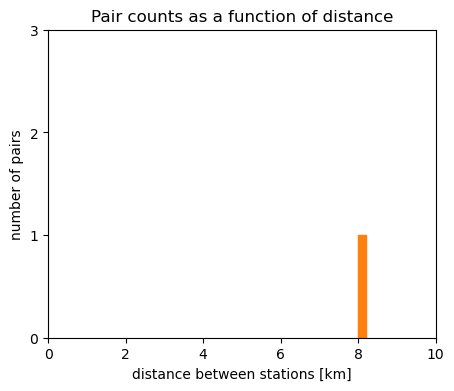

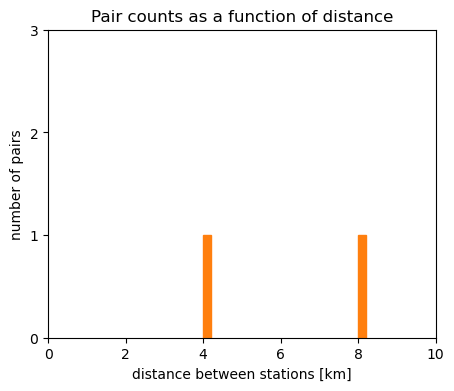

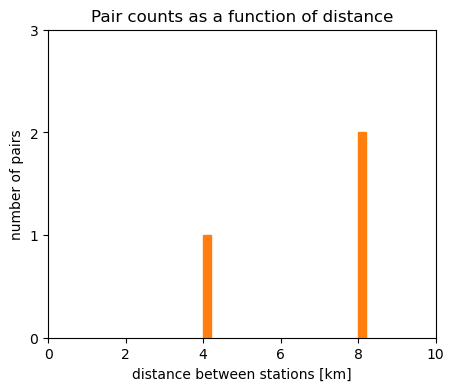

In [7]:
wide_edges = np.linspace(0., 10., 51)
wide_sep = (wide_edges[:-1] + wide_edges[1:]) / 2.
indices = [([40], [1]), ([40, 20], [1, 1]), ([40, 20], [2, 1])]
for i, (index, values) in enumerate(indices):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.bar([wide_sep[idx] for idx in index], values, width=wide_edges[1] - wide_edges[0], color='C1', edgecolor='C1')
    ax.set_xlim(wide_edges[0], wide_edges[-1])
    y = list(range(4))
    ax.set_ylim(y[0], y[-1])
    ax.set_yticks(y)
    ax.set_xlabel('distance between stations [km]')
    ax.set_ylabel('number of pairs')
    ax.set_title('Pair counts as a function of distance')
    fig.savefig(plot_dir / 'DD_histo_{:d}.{}'.format(i, ext), **kw_fig)

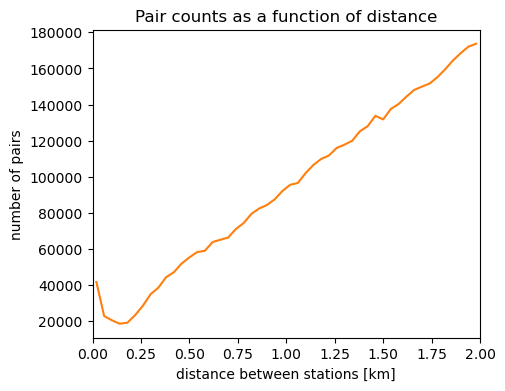

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(sep, DD, color='C1')
ax.set_xlim(edges[0], edges[-1])
ax.set_xlabel('distance between stations [km]')
ax.set_ylabel('number of pairs')
ax.set_title('Pair counts as a function of distance')
fig.savefig(plot_dir / 'DD_counts.{}'.format(ext), **kw_fig)

We see a peak close to 0, then a rising slope at large separations (1 km).
How to explain this? What would we obtain with a purely random distribution?

## 1 - Uniform randoms in a $x$-$y$ box

In [9]:
rng = np.random.RandomState(seed=42)
# Generate random points uniformly distributed in the same box as the data
nrandoms = len(data_positions) * 4  # 4 times the number of data points
# Generate random positions within the bounding box of the data
data_min = np.min(data_positions, axis=0)
data_max = np.max(data_positions, axis=0)
randoms_positions = np.column_stack([rng.uniform(data_min[i], data_max[i], size=nrandoms) for i in [0, 1]])

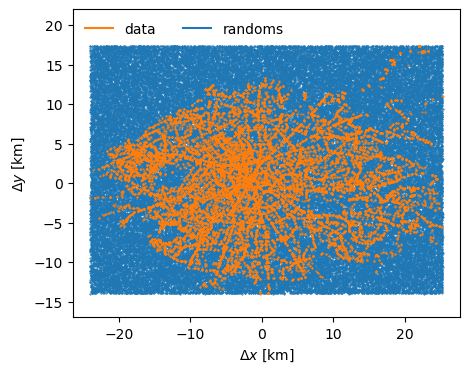

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
# Scatter plot of random points and data points
ax.plot([], [], color='C1', label='data')
ax.plot([], [], color='C0', label='randoms')
ax.scatter(randoms_positions[:, 0], randoms_positions[:, 1], marker='.', s=1, color='C0')
ax.scatter(data_positions[:, 0], data_positions[:, 1], marker='.', s=1, color='C1')
ax.set_xlabel('$\Delta x$ [km]')
ax.set_ylabel('$\Delta y$ [km]')
ax.set_ylim(-17., 22.)
ax.legend(ncols=2, loc=2, frameon=False)
fig.savefig(plot_dir / 'map_data_randoms_naive.{}'.format(ext), **kw_fig)

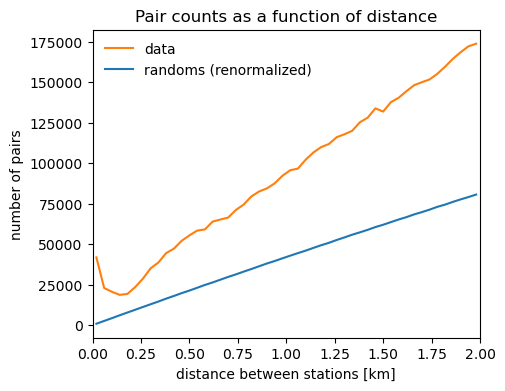

In [11]:
# Count pairs of random points within the specified distance range
RR = pair_count_2d(randoms_positions, edges)

nd, nr = len(data_positions), len(randoms_positions)
factor = nd**2 / nr**2

fig, ax = plt.subplots(figsize=(5, 4))
# Plot the pair counts for data points
ax.plot(sep, DD, color='C1', label='data')
# Plot the pair counts for random points
ax.plot(sep, RR * factor, color='C0', label='randoms (renormalized)')
ax.set_xlim(edges[0], edges[-1])
ax.set_xlabel('distance between stations [km]')
ax.set_ylabel('number of pairs')
ax.set_title('Pair counts as a function of distance')
ax.legend(frameon=False)
fig.savefig(plot_dir / 'DD_RR_naive_counts.{}'.format(ext), **kw_fig)

Match isn't very satisfactory!

## 2 - Randoms that match the footprint of the data

In an ideal world, we would know where there is non-zero probability to find a metro station at any location of the Paris area. E.g., we know there is zero chance to find a metro station anywhere else than a metro line. So we could e.g., generate random points only on metro lines.
Let's try something simpler: place randoms where there are stations.

In [12]:
# Create 2D data histogram
hist, xedges, yedges = np.histogram2d(data_positions[:, 0], data_positions[:, 1], bins=20)
hist = hist / hist.max()  # make it a probability

# Generate uniformly distributed randoms
nrandoms = len(data_positions) * 20
randoms_positions = np.column_stack([rng.uniform(data_min[i], data_max[i], size=nrandoms) for i in [0, 1]])
# Bin randoms in the 2D space
xidx = np.digitize(randoms_positions[:, 0], bins=xedges) - 1
yidx = np.digitize(randoms_positions[:, 1], bins=yedges) - 1

# Downsample randoms to match the amplitude of the 2D data hist
prob = rng.uniform(0., 1., nrandoms)
mask = prob < hist[xidx, yidx]
randoms_positions = randoms_positions[mask]

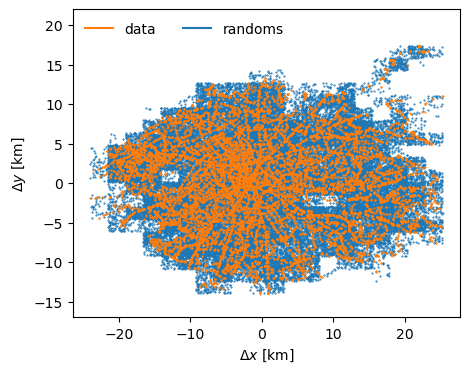

In [13]:
fig, ax = plt.subplots(figsize=(5, 4))
# Scatter plot of random points and data points
ax.plot([], [], color='C1', label='data')
ax.plot([], [], color='C0', label='randoms')
ax.scatter(randoms_positions[:, 0], randoms_positions[:, 1], marker='.', s=1, color='C0')
ax.scatter(data_positions[:, 0], data_positions[:, 1], marker='.', s=1, color='C1')
ax.set_xlabel('$\Delta x$ [km]')
ax.set_ylabel('$\Delta y$ [km]')
ax.set_ylim(-17., 22)
ax.legend(ncols=2, loc=2, frameon=False)
fig.savefig(plot_dir / 'map_data_randoms.{}'.format(ext), **kw_fig)

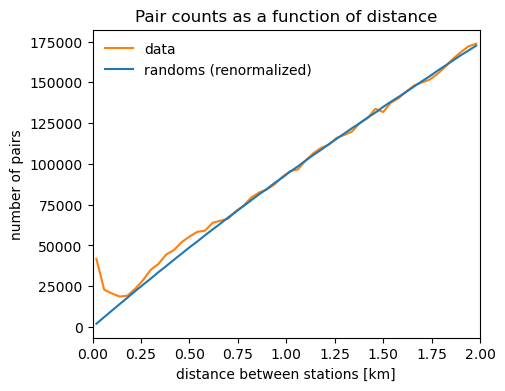

In [14]:
# Count pairs of random points within the specified distance range
RR = pair_count_2d(randoms_positions, edges)

nd, nr = len(data_positions), len(randoms_positions)
factor = nd**2 / nr**2

fig, ax = plt.subplots(figsize=(5, 4))
# Plot the pair counts for data points
ax.plot(sep, DD, color='C1', label='data')
# Plot the pair counts for random points
ax.plot(sep, RR * factor, color='C0', label='randoms (renormalized)')
ax.set_xlim(edges[0], edges[-1])
ax.set_xlabel('distance between stations [km]')
ax.set_ylabel('number of pairs')
ax.set_title('Pair counts as a function of distance')
ax.legend(frameon=False)
fig.savefig(plot_dir / 'DD_RR_counts.{}'.format(ext), **kw_fig)

Match is now pretty good! Let's compute...

# The correlation function

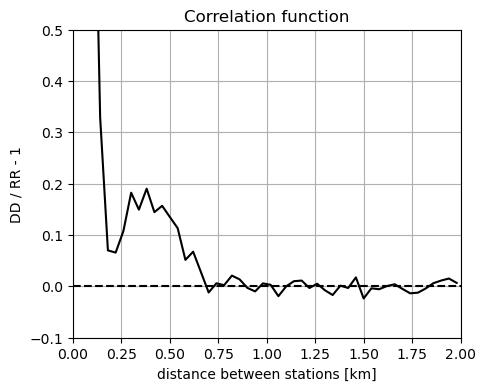

In [15]:
nd, nr = len(data_positions), len(randoms_positions)
xi = DD / (nd * (nd - 1)) / (RR / (nr * (nr - 1))) - 1

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(sep, xi, color='k')
ax.axhline(0., color='k', linestyle='--')
ax.set_xlim(edges[0], edges[-1])
ax.set_ylim(-0.1, 0.5)
ax.set_xlabel('distance between stations [km]')
ax.set_ylabel('DD / RR - 1')
ax.set_title('Correlation function')
ax.grid(True)
fig.savefig(plot_dir / 'correlation_function.{}'.format(ext), **kw_fig)

We notice:
- at small distance $< 200$ meters, an excess probability to find 2 close stations (e.g. Chatelet) w.r.t. a random distribution
- a bump at $400$ meters, "ideal distance" between stations (transportation time $\lesssim$ walking time)